# Lab 4: Building a Spotify Song Classifier with KNNs and Decision Trees
**Classify by genres**. In this lab, you will build machine learning genre classifiers using a dataset of Spotify tracks. Your goal is to train a model that can distinguish between two selected genres based on various audio features such as danceability, energy, valence, tempo, and more.

We'll follow the familiar workflow of data exploration -> preprocessing -> model training -> evaluation

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

### Step 1: The data
We'll focus on two genres: Blues and Jazz (what’s the difference, anyway??).

Both genres have rich musical histories, but they differ in structure:

- Blues tends to have simpler chord progressions and a strong emotional expression.
- Jazz often involves complex improvisation and more varied rhythms.

But can a machine really tell them apart just by looking at numerical audio features? That’s what we’ll find out!

In this step, you will:
- Load the dataset
- Extract only blues and jazz for classification

In [2]:
spotify_data = pd.read_csv('/courses/EDS232/Data/spotify_dat.csv')

# Print the data types in spotify_data
print(spotify_data.info())
#print(spotify_data.head())
# Filter down to two genres
blues_data = spotify_data[spotify_data['genres'].str.contains("blues", na=False)]
jazz_data =  spotify_data[spotify_data['genres'].str.contains("jazz", na=False)]

# Combine both genres into one dataset
combined_data = pd.concat([blues_data, jazz_data])#.reset_index(drop=True)

# Rename 'genres' column to 'genre' for clarity
combined_data = combined_data.rename(columns={'genres':'genre'})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204025 entries, 0 to 1204024
Data columns (total 25 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1204025 non-null  object 
 1   name              1204022 non-null  object 
 2   album             1204014 non-null  object 
 3   album_id          1204025 non-null  object 
 4   artists           1204025 non-null  object 
 5   artist_ids        1204025 non-null  object 
 6   track_number      1204025 non-null  int64  
 7   disc_number       1204025 non-null  int64  
 8   explicit          1204025 non-null  bool   
 9   danceability      1204025 non-null  float64
 10  energy            1204025 non-null  float64
 11  key               1204025 non-null  int64  
 12  loudness          1204025 non-null  float64
 13  mode              1204025 non-null  int64  
 14  speechiness       1204025 non-null  float64
 15  acousticness      1204025 non-null  float64
 16  

## Step 2: Data Exploration
Now that we have Blues and Jazz as our two genres, it's time to explore the data and look for patterns in the audio features.

Let's investigate:
- Which features are available?
- How strongly these features correlate with each other.
- How different genres distribute across  sample features: danceability 

In this step, we will:
- Filter out non-numeric columns before the plotting
- Visualize feature correlations using a heatmap.
- Examine key feature distributions with histograms to see if genres behave differently.


<Axes: >

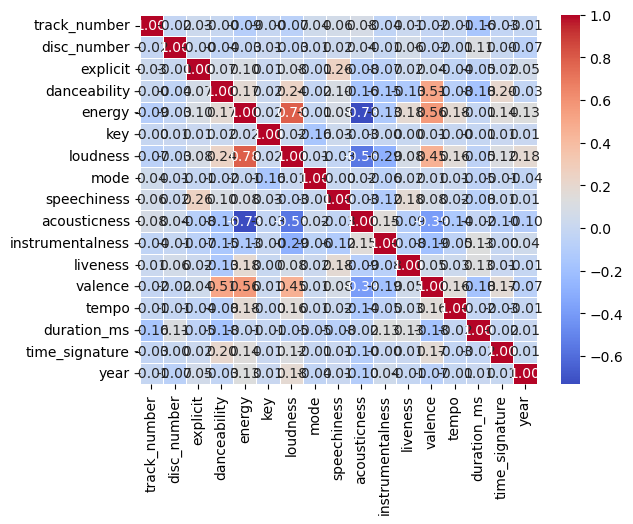

In [7]:
# Exclude non-numeric columns but keep 'genre' for grouping
numeric_features = combined_data.select_dtypes(include=['int64','bool', 'float64'])
numeric_features['genre'] = combined_data['genre']

#Correlation heatmap
cm = numeric_features.drop(columns=['genre']).corr()
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

#Histogram of danceability





### Step 3: Check for class imbalance
An unequal distribution between the target classes can cause issues for our classifiers, so we'll need to check for that. A commonly used guideline for class imbalance is:

- Slight Imbalance (Less than 1.5:1) → Generally okay; no need for balancing.
- Moderate Imbalance (Between 1.5:1 and 3:1) → Might cause some bias; balancing can help.
- Severe Imbalance (More than 3:1) → Strongly affects model performance; balancing is usually necessary.

In [ ]:
# Print counts of each genre
class_counts = 

# Calculate ratio of majority to minority class
class_ratio = 

# Print class distribution and ratio


Given this result, should we be worried about the imbalance?

*your answer here*

### Step 4: Preprocessing
We need to ensure all the variables we use are numerical so the models can process them. First we'll drop all the variables that are not numeric or the target. Then we'll use a sklearn utility, `LabelEncoder()` to encode our categorical target variable into numerical values. Print the first five values of your encoded labels.

In [ ]:
# Define the features (drop columns that are not numeric or target)
X = 

# Set the target variable as 'genre'
y =  

# Encode the target variable ('label') using label encoding
label_encoder = 
y_encoded =

# Print first five values of encoded labels


Good, now we'll do our data splitting and scaling.  Let's go with an 80/20 split this time.

In [ ]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = 

# Initialize the scaler
scaler = 

# Fit and transform only the training set
X_train_scaled = 

# Use the same scaler to transform the test set
X_test_scaled = 



### Step 5: Train the models
OK, now it's time to build our models and assess the training accuracy. We'll use the default of k = 5 for the KNN model.

In [ ]:
# Initialize models
knn = 
dt = 

# Train (fit) both models


# Predictions on training data
knn_y_train_pred = 
dt_y_train_pred = 

# Compute training accuracy
knn_train_accuracy = 
dt_train_accuracy = 

#Print training accuracy for both models


### Step 6: Evaluate models
OK, now let's go ahead and predict on the test data to see how well our models do at predicting the genre of unseen tracks.

In [ ]:
# Make predictions
knn_pred = 
dt_pred = 

# Evaluate prediction accuracy
knn_accuracy = 
dt_accuracy = 

#Print prediction accuracy for both models


### Step 7: Visualizing Model Performance
Now that we have evaluated our models on unseen data, let’s compare their performance by visualizing the training vs. test accuracy.  We'll look for signs of overfitting by plotting the training accuracy and test accuracy for both k-NN and Decision Trees.

Create a bar chart that compares the training accuracy and test accuracy for k-NN and Decision Trees. Your plot should clearly display:

- The training and test accuracy for both models.
- Properly labeled axes and a title.
- A legend to differentiate training and test accuracy.
- Accuracy values displayed on top of each bar.

Which model does a better job of generalizing to unseen data? How do you know?
Does it appear that either of the models are overfitting? Why?

*your anwer here*

### Bonus question
In the workflow above, we used the default parameter values of k = 5 for the KNN model, and maxdepth = None for the Decision Tree. Choose one of the models and see if you can improve test performance by optmizing its corresponding parameter value.